# Real-word Trade-in Values of Car Brands

## Import packages

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

In [2]:

from pathlib import Path
path = Path.cwd() # current working directory


## Task: Scrapping data and process the data using NLTK 

### Scrapping latest 5000 posts and store in post_text

In [3]:
post_text=[]
for i in range(994,1095):
    url='https://forums.edmunds.com/discussion/1212/general/x/real-world-trade-in-values/p'+str(i)
    page=requests.get(url)
    page_text=page.text
    soup=BeautifulSoup(page_text, 'html.parser')
    post_text_elem= soup.find_all(class_="Message userContent")
    for item in post_text_elem:
        post_text.append(item.text.lstrip())
post_text = post_text[35:5035]


### Tokenize/remove stopwords/lemmatize

In [4]:
def tokenizer(words) -> list:
    tokenizer = RegexpTokenizer(r'[\w-]+')
    tokens = tokenizer.tokenize(words.lower())

    stopwords_set = set(stopwords.words('english')) # use build in english package
    lemmatizer = WordNetLemmatizer()

    return [lemmatizer.lemmatize(token, pos='v') for token in tokens if token not in stopwords_set]

#apply tokenizer function to each post, using set to remove the repeat and store in processed text
processed_text = []
for comment in post_text:
    processed_text.append(list(set(tokenizer(comment))))

## Task: Find the top 10 brands from frequency counts

$\textbf{Note:}$ Some people just use model name of a car instead of mentioning the brand name. Thus, we choose to convert the model name to the brand name and count frequency of each brand based on the converted text.

To do so, we created a model_csv that stores the informaiton of car brand and the popular models under the brands.

### Import model_csv and process

In [5]:
model_grid = pd.read_csv(path.joinpath('models.csv'))

model_grid['Brands'] = model_grid['Brands'].str.lower()
model_grid['model']  = model_grid['model'].str.lower()
model_grid = model_grid[['Brands','model']]

In [6]:
model_grid

,Brands,model
0,acura,cl
1,acura,ilx
2,acura,mdx
3,acura,nsx
4,acura,rdx
...,...,...
1642,maserati,gt coupe
1643,maserati,levante
1644,maserati,mc12
1645,maserati,quattroporte


### Calculate model frequency  

In [13]:
# Replace the model with its brand in the processed_text
remove_dup = []
for comment in processed_text: 
    for i in range(len(comment)): 
        if comment[i] in model_grid.model.tolist():
            condition = model_grid['model'] == comment[i]
            brand_index = model_grid.index[condition].tolist()
            comment[i] = model_grid['Brands'].iloc[brand_index[0]]
    remove_dup.append(list(set(comment)))
fre = defaultdict(int)

In [14]:
for p in remove_dup:
    for w in p:
        if w in model_grid.Brands.tolist():
            fre[w] += 1

### Convert the brand frequency to dataframe and keep the top 10 brands

In [15]:
brand_frequency = dict(fre)
br = brand_frequency.keys()
fre = brand_frequency.values()
df = pd.DataFrame()
df['brand'] = br
df['frequency'] = fre

#include top 10 brand and its frequency
top = df.sort_values(by = 'frequency', ascending= False).head(10)

#top 10 brand
top

,brand,frequency
14,honda,378
7,chevrolet,280
16,toyota,274
9,ford,261
13,fiat,251
34,bmw,251
12,audi,234
32,volkswagen,220
1,subaru,193
15,nissan,191


In [16]:
top_10 = top.brand.tolist() ## create list that record the name of top 10 brand.

## Task: Calculate lift ratios for associations between top 10 brands

### Getting the combination of 10 brands to calculate the lift

In [17]:
from itertools import combinations
comb = list(combinations(top_10,2))

### Create a sub-dataframe to store the model for top10 brands

In [18]:
target_df = model_grid[model_grid['Brands'].isin(top_10)]
target_df = target_df.reset_index(drop = True)
target_df

,Brands,model
0,audi,a1
1,audi,a2
2,audi,a3
3,audi,a4
4,audi,a4 allroad
...,...,...
411,volkswagen,transporter shuttle
412,volkswagen,up!
413,volkswagen,vento
414,volkswagen,voyage


### Replace the model with its brand in the processed_text

In [19]:
for comment in processed_text: 
    for i in range(len(comment)): 
        if comment[i] in target_df.model.tolist():
            condition = target_df['model'] == comment[i]
            brand_index = target_df.index[condition].tolist()
            comment[i] = target_df['Brands'].iloc[brand_index[0]]

### Getting a narrowed list of the posts that contains target brands

In [20]:
target_comment = []
for comment in processed_text:
    for words in comment:
        if words in top_10:
            target_comment.append(list(set(comment)))
#remove duplicate
target_comment_distinct = []
for i in target_comment:
    if i not in target_comment_distinct:
        target_comment_distinct.append(i)
        


### Calculate the #(A,B) 

In [21]:
pair_frequency = {}
for i in comb:
    pair_frequency[i] = 0
for pair in comb:
    for comm in target_comment_distinct:
        if pair[0] in comm and pair[1] in comm:
            pair_frequency[pair] +=1

### Calculate lift

In [23]:
lift = defaultdict(int)
for i in pair_frequency.keys():
    lift[i] = (5000*pair_frequency[i]) / (brand_frequency[i[0]]*brand_frequency[i[1]])

In [24]:
for i in lift:
    if lift[i] == 0: ## some time two brand has not been mentioned together at all,we need to set a base value for lift
        lift[i] = 1

In [25]:
df_lifts = pd.DataFrame(columns=top_10,index=top_10)
for brand in top_10: 
    df_lifts[brand][brand] = '-'
for brands in lift:
    a,b = brands
    df_lifts[a][b] = (lift[brands])
    df_lifts[b][a] = '-'

In [26]:
df_lifts

,honda,chevrolet,toyota,ford,fiat,bmw,audi,volkswagen,subaru,nissan
honda,-,-,-,-,-,-,-,-,-,-
chevrolet,1.08655,-,-,-,-,-,-,-,-,-
toyota,1.30344,2.8024,-,-,-,-,-,-,-,-
ford,1.67244,2.59989,1.46824,-,-,-,-,-,-,-
fiat,2.37147,1.84974,1.81755,1.22117,-,-,-,-,-,-
bmw,0.948587,1.06716,1.09053,0.534261,1.82537,-,-,-,-,-
audi,1.24361,0.686813,0.467902,0.409339,0.851296,0.936425,-,-,-,-
volkswagen,2.04425,3.24675,1.49303,1.74155,0.814922,0.633828,2.52525,-,-,-
subaru,1.78194,2.03553,1.7019,1.38963,0.309642,0.51607,1.54998,1.17758,-,-
nissan,0.831048,1.49589,0.859862,1.10329,1.9816,1.14724,1,0.475964,2.71275,-


In [27]:
top_brand_lifts = pd.DataFrame(columns=top_10,index=top_10)
for brands in lift:
    a,b = brands
    top_brand_lifts[a][b] = (1/lift[brands])
    top_brand_lifts[b][a] = (1/lift[brands])
for brand in top_10: 
    top_brand_lifts[brand][brand] = 0

In [28]:
top_brand_lifts

,honda,chevrolet,toyota,ford,fiat,bmw,audi,volkswagen,subaru,nissan
honda,0,0.920348,0.7672,0.597927,0.42168,1.0542,0.804109,0.489176,0.561185,1.2033
chevrolet,0.920348,0,0.356837,0.384632,0.540615,0.937067,1.456,0.308,0.491273,0.6685
toyota,0.7672,0.356837,0,0.681086,0.550192,0.916987,2.1372,0.669778,0.587578,1.16298
ford,0.597927,0.384632,0.681086,0,0.818887,1.87174,2.44296,0.5742,0.719614,0.906382
fiat,0.42168,0.540615,0.550192,0.818887,0,0.547835,1.17468,1.22711,3.22953,0.504642
bmw,1.0542,0.937067,0.916987,1.87174,0.547835,0,1.06789,1.57771,1.93772,0.871655
audi,0.804109,1.456,2.1372,2.44296,1.17468,1.06789,0,0.396,0.645171,1
volkswagen,0.489176,0.308,0.669778,0.5742,1.22711,1.57771,0.396,0,0.8492,2.101
subaru,0.561185,0.491273,0.587578,0.719614,3.22953,1.93772,0.645171,0.8492,0,0.36863
nissan,1.2033,0.6685,1.16298,0.906382,0.504642,0.871655,1,2.101,0.36863,0


## Task:  Plot the top 10 brands on a multidimensional scaling (MDS) map

In [29]:
from sklearn import manifold
import matplotlib.pyplot as plt
mds = manifold.MDS(dissimilarity='euclidean',random_state=522)
mds_fit = mds.fit(top_brand_lifts)
coords = mds.fit_transform(top_brand_lifts)

/Users/hong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/Users/hong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


Text(0.5, 1.0, 'Multidimensional Scaling: Top 10 Brands \n (Euclidean Distances = 1 / lift)')

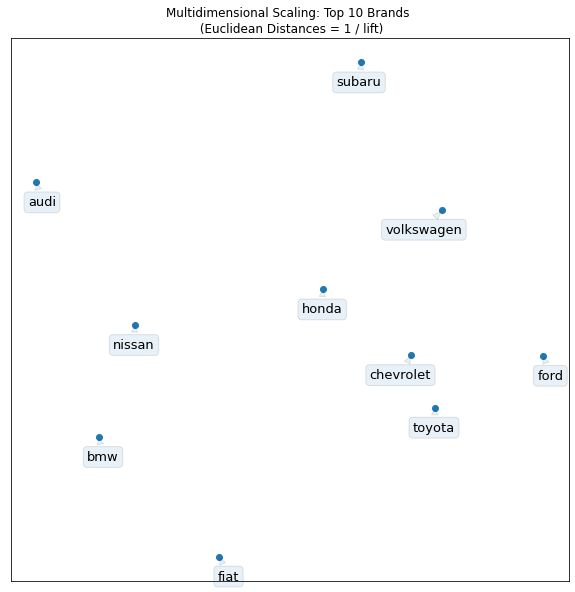

In [30]:
x,y = coords.T

plt.figure(figsize=(10, 10))
plt.scatter(x,y)

for i, txt in enumerate(top_10):
    plt.annotate(txt, (x[i], y[i]), xycoords='data',
             xytext=(20, -20), textcoords='offset points',
             size=13, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1))
    
plt.yticks([])
plt.xticks([])
plt.title('Multidimensional Scaling: Top 10 Brands \n (Euclidean Distances = 1 / lift)')

 ## Task: Offer insights to two top 10 brands based on the analysis above.

Based on our analysis of the real-trade-in value forum on Edmunds.com, Volkswagen and Chevrolet appear to have the highest lift (3.25), which means that there’s a positive association between these two brands. Chevrolet is more likely to be mentioned in conjunction with Volkswagen than other brands. The frequency of occurrence of Chevrolet and Volkswagen is 40 among the total comments scraped.

One of the possible reasons for such a high co-occurrence of these 2 brands in comments is that they have either very similar or very different trade-in values. When people discuss trade-in values, they tend to mention both of these brands at the same time to make comparisons. Therefore, brand managers of both Volkswagen and Chevrolet should be aware that the other brand is a potential competitor in the used car market. Some buyers who want to change hands their cars shortly might consider the trade-in values when buying the new car. Potential adjustments in production or after-sales service may affect the trade-in value, thus affecting the sales and profits.

According to our research of the two brands, we found that they have overlapped target markets. Although these two brands may have different strategies in the new car market, when it comes to used car sales, customers’ standards tend to become similar. And sometimes, the trade-in value would also become an important feature. Especially for target customers of Volkswagen and Chevrolet, the age range indicates they may be in a stage that is not that stable and face the trade-in in the near future such as single to married or married to have children. Therefore, it is worth thinking for the brand managers of Volkswagen and Chevrolet that the higher trade-in value/reliability can become a selling point for those customers.


## Task: Analyze most frequently mentioned attributes of cars in the discussions

To calculate the most frequently mentioned attributes of cars in the discussions, we then look for the attributes from the narrowed list of the posts that contains brand (the target comment we got in previous section).

But rather than using this list directly, we remove the verbs, conjunctions and prepositions using the tagging feature of NLTK.

### Tagging words in target comment

In [31]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/hong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hong/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [32]:
wordlist = []
for i in range(len(target_comment)):
    for j in range(len(target_comment[i])):
        wordlist.append(target_comment[i][j])
text = ' '.join(wordlist).lower()

In [33]:
tokens = nltk.word_tokenize(text)

In [34]:
tags = nltk.pos_tag(tokens)

In [35]:
## list of noun and adj words
n_adj_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' 
                                             or pos == 'VBD' or pos == 'JJ' or pos == 'JJR' or pos == 'JJS'
                                             or pos =='RB' or pos =='RBR'or pos =='RBS')]
## list of adj only
adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]

Firstly we did a word cloud based on the noun and adjs in the selecteed posts, to have a brief idea of the attributes that have involved in the discussion.

In [36]:
n_adj_string=(" ").join(n_adj_list)
adj_string=(" ").join(adj_list)

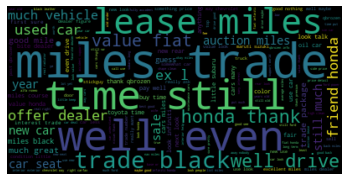

In [37]:
wordcloud1 = WordCloud().generate(n_adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

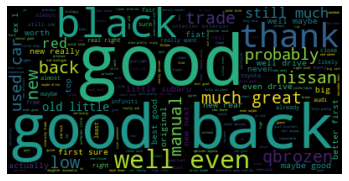

In [38]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

### Calculate the frequency of words 

In [39]:
#count the words frequency and sort
from collections import Counter
counts = Counter(n_adj_list)


## Task: Create the list of attribute based on the frequently mentioned words

After counting the occurrences of each selected word, ranked them by the number of occurrences. We manually selected meaningful descriptive words for cars and categorized them into 11 attributes: range, performance, comfort, vehicle architecture, safety, drivability, interior, sound, thermal management, energy management, appearance, and cost efficiency. (Reference of the attribute and how they have been categorized:https://www.avl.com/-/vehicle-attributes)

Since we have already counted the occurrences of each particular word that describes vehicles, we summed up the number of occurrences of each word under each of the attribute categories to get the frequency of each attribute.

The result was inputed into a attribute.csv.

In [40]:
#import attributes csv
attributes = pd.read_csv(path.joinpath('attributes.csv'))

In [41]:
attributes.head()

,range,range_f,performance,performance_f,comfort,comfort_f,vehicle_architecture,vehicle_architecture_f,safety,safety_f,...,interior_sound,interior_sound_f,thermal_management,thermal_management_f,energy_management,energy_management_f,appearance,appearance_f,cost_efficiency,cost_efficiency_f
0,last,198.0,manual,125.0,leather,93.0,year,276,accident,110.0,...,interior,161.0,oil,51.0,power,52.0,new,505,trade,408.0
1,months,146.0,pick,50.0,vroom,80.0,condition,246,repair,109.0,...,radio,21.0,hybrid,29.0,gas,35.0,look,470,dealer,418.0
2,road,59.0,heat,49.0,small,60.0,model,159,damage,89.0,...,noise,14.0,equipment,19.0,equipment,19.0,black,234,value,470.0
3,speed,56.0,quick,49.0,sit,51.0,seat,133,accidents,72.0,...,speakers,11.0,electrical,18.0,electrical,18.0,old,188,pay,260.0
4,hour,20.0,roadburner,42.0,size,49.0,engine,126,reliable,36.0,...,NaN,NaN,radiator,18.0,battery,13.0,blue,139,cheap,64.0


## Task: Find attributes that are most strongly associated with top 5 brands

In [42]:
s = attributes[['range_f', 'performance_f', 'comfort_f', 'vehicle_architecture_f','safety_f', 'drivability_f', 'interior_sound_f', 'thermal_management_f', 'energy_management_f', 'appearance_f','cost_efficiency_f']].sum()

In [43]:

attr = s.sort_values(ascending=False)
attr = pd.DataFrame({'attributes':attr.index, 'frequency':attr.values})
attr

,attributes,frequency
0,cost_efficiency_f,2312.0
1,appearance_f,2026.0
2,drivability_f,1447.0
3,vehicle_architecture_f,1287.0
4,range_f,545.0
5,safety_f,485.0
6,comfort_f,481.0
7,performance_f,394.0
8,interior_sound_f,207.0
9,energy_management_f,162.0


### Top 5 car brands' frequency and lift for attributes that mentioned in the discussion

In [44]:
##From TASK A we get the most frequently mentioned brands are:
top5 = df.sort_values(by = 'frequency', ascending= False).head(5)
top5

,brand,frequency
14,honda,378
7,chevrolet,280
16,toyota,274
9,ford,261
13,fiat,251


In [45]:
import itertools
attlist = []
brandlist = []
for i in attr['attributes']:
    attlist.append(i)
    
for i in top5['brand']:
    brandlist.append(i) 

all_combinations = list(itertools.product(brandlist, attlist))


In [46]:
com = []
for i in range(len(all_combinations)):
    com.append(all_combinations[i])

#to remove duplicated combinations
com = list(set(com))

## Task: Calculate the lift values for each pair of (brand, attribute)

### Calculate the frequency #(Brand, attribute)

In [47]:
import copy
comment_copy = copy.deepcopy(target_comment)

In [48]:
#to replace each specific attribute words with attributes categories in the text

for j in range(len(target_comment)):
    for i in range(len(target_comment[j])):
        if target_comment[j][i] in attributes.cost_efficiency.dropna().tolist():
            target_comment[j][i] = 'cost_efficiency_f'
            continue
        if target_comment[j][i] in attributes.appearance.dropna().tolist():
            target_comment[j][i] = 'appearance_f'
            continue
        if target_comment[j][i] in attributes.drivability.dropna().tolist():
            target_comment[j][i] = 'drivability_f'
            continue
        if target_comment[j][i] in attributes.range.dropna().tolist():
            target_comment[j][i] = 'range_f'
            continue
        if target_comment[j][i] in attributes.vehicle_architecture.dropna().tolist():
            target_comment[j][i] = 'vehicle_architecture_f'
            continue
        if target_comment[j][i] in attributes.performance.dropna().tolist():
            target_comment[j][i] = 'performance_f'
            continue
        if target_comment[j][i] in attributes.comfort.dropna().tolist():
            target_comment[j][i] = 'comfort_f'
            continue
        if target_comment[j][i] in attributes.safety.dropna().tolist():
            target_comment[j][i] = 'safety_f'
            continue
        if target_comment[j][i] in attributes['interior_sound'].tolist():
            target_comment[j][i] = 'interior_sound_f'
            continue
        if target_comment[j][i] in attributes.thermal_management.dropna().tolist():
            target_comment[j][i] = 'thermal_managemen_f'
            continue
        if target_comment[j][i] in attributes.energy_management.dropna().tolist():
            target_comment[j][i] = 'energy_management_f'
            continue

In [49]:
## Calculate the frequency #(Brand, attribute)
pair_f = defaultdict(int)
for pair in com:

    for comment in target_comment:
        if pair[0] in comment and pair[1] in comment:

            pair_f[pair] +=1


In [50]:
## Store into a dictionary
brand_dict = {}
for (key, value) in brand_frequency.items():
    if key in top5.brand.tolist():
        brand_dict[key] = value
att_dict = dict(zip(attr.attributes, attr.frequency))
att_dict

{'cost_efficiency_f': 2312.0,
 'appearance_f': 2026.0,
 'drivability_f': 1447.0,
 'vehicle_architecture_f': 1287.0,
 'range_f': 545.0,
 'safety_f': 485.0,
 'comfort_f': 481.0,
 'performance_f': 394.0,
 'interior_sound_f': 207.0,
 'energy_management_f': 162.0,
 'thermal_management_f': 148.0}

In [51]:
#Calculate Lift
liftC = defaultdict(int)
for i in pair_f.keys():
    
    liftC[i] = (5000*pair_f[i]) / (brand_dict[i[0]]*att_dict[i[1]])

### Create dataframe that store the lift values for each brand

In [52]:
honda_attr_lift = pd.DataFrame(columns=["attribute","Lift"])
for i in liftC.keys():
    if i[0] == 'honda':
        honda_attr_lift = honda_attr_lift.append({'attribute': i[1], 'Lift': liftC[i]}, ignore_index=True)

In [53]:
honda_attr_lift = honda_attr_lift.sort_values(by = 'Lift', ascending= False)

In [54]:
honda_attr_lift

,attribute,Lift
5,comfort_f,6.545007
9,interior_sound_f,6.070598
3,range_f,5.388088
0,drivability_f,5.055159
6,performance_f,4.767276
7,energy_management_f,4.735776
1,safety_f,4.554628
8,vehicle_architecture_f,3.864448
4,appearance_f,3.695347
2,cost_efficiency_f,3.255387


In [55]:
chevrolet_attr_lift = pd.DataFrame(columns=["attribute","Lift"])
for i in liftC.keys():
    if i[0] == 'chevrolet':
        chevrolet_attr_lift = chevrolet_attr_lift.append({'attribute': i[1], 'Lift': liftC[i]}, ignore_index=True)

chevrolet_attr_lift = chevrolet_attr_lift.sort_values(by = 'Lift', ascending= False)

In [56]:
chevrolet_attr_lift

,attribute,Lift
4,range_f,6.815203
6,performance_f,6.390500
7,energy_management_f,4.960317
0,drivability_f,4.726528
5,comfort_f,4.566380
9,vehicle_architecture_f,4.218004
3,appearance_f,3.842899
1,safety_f,3.792342
8,interior_sound_f,3.278123
2,cost_efficiency_f,3.228497


In [57]:
toyota_attr_lift = pd.DataFrame(columns=["attribute","Lift"])
for i in liftC.keys():
    if i[0] == 'toyota':
        toyota_attr_lift = toyota_attr_lift.append({'attribute': i[1], 'Lift': liftC[i]}, ignore_index=True)

toyota_attr_lift = toyota_attr_lift.sort_values(by = 'Lift', ascending= False)

In [58]:
toyota_attr_lift

,attribute,Lift
8,comfort_f,7.322033
4,safety_f,5.907141
7,range_f,5.725574
9,performance_f,5.511505
1,interior_sound_f,5.465637
3,drivability_f,5.246193
2,vehicle_architecture_f,4.111865
6,appearance_f,3.909037
0,energy_management_f,3.604578
5,cost_efficiency_f,3.354444


In [59]:
ford_attr_lift = pd.DataFrame(columns=["attribute","Lift"])
for i in liftC.keys():
    if i[0] == 'ford':
        ford_attr_lift = ford_attr_lift.append({'attribute': i[1], 'Lift': liftC[i]}, ignore_index=True)

ford_attr_lift = ford_attr_lift.sort_values(by = 'Lift', ascending= False)

In [60]:
ford_attr_lift

,attribute,Lift
5,performance_f,7.487796
7,interior_sound_f,7.218613
4,comfort_f,7.129145
6,energy_management_f,6.858711
2,range_f,6.784070
9,drivability_f,5.097083
8,vehicle_architecture_f,4.807878
3,appearance_f,3.659325
1,cost_efficiency_f,3.380663
0,safety_f,3.001935


In [61]:
fiat_attr_lift = pd.DataFrame(columns=["attribute","Lift"])
for i in liftC.keys():
    if i[0] == 'fiat':
        fiat_attr_lift = fiat_attr_lift.append({'attribute': i[1], 'Lift': liftC[i]}, ignore_index=True)

fiat_attr_lift = fiat_attr_lift.sort_values(by = 'Lift', ascending= False)

In [62]:
fiat_attr_lift

,attribute,Lift
9,performance_f,6.319898
8,comfort_f,5.590942
6,range_f,4.532329
3,drivability_f,4.350256
2,vehicle_architecture_f,3.219445
1,interior_sound_f,2.983236
7,appearance_f,2.949702
5,cost_efficiency_f,2.593432
0,energy_management_f,2.336334
4,safety_f,2.300078


## Task: Analyze attribute detail of top 5 brand and provide insights to product manager, and marketing/advertising team of the brands.

First import detail_attribute dataset. This is just a csv with a list of uncateforized attribute.

In [63]:
detial_attributes = pd.read_csv(path.joinpath('detail_attribute.csv'))

In [64]:
detial_attributes = detial_attributes.detail_attribute.values

### For Honda:

In [65]:
## filter out honda related comment
honda_comment = []
for comment in comment_copy:
    if 'honda' in comment:
        honda_comment.append(list(set(comment)))


In [66]:
## calculate the frequency of each detailed attribute
honda_attr = defaultdict(int)
for comment in honda_comment:
    for attr in detial_attributes:
        if attr in comment:

            honda_attr[attr] +=1


In [67]:
honda_attr = pd.DataFrame(list(zip(honda_attr.keys(), honda_attr.values())),columns =['attribute', 'frequency'])
honda_attr = honda_attr.sort_values(by = 'frequency', ascending= False)

In [68]:
honda_attr.head(10)

,attribute,frequency
6,new,210
16,condition,141
1,black,120
5,deal,118
14,old,104
18,lease,94
20,mileage,91
30,seat,82
4,interior,82
37,engine,67


#### Advice for product managers:

The two top 5 brands that are highly associated with Honda are Fiat and Ford. Compared to Fiat and Ford, Honda has a relatively low lift score in the energy management and performance attributes. In order to become more competitive, Honda product managers should consider enhancing the performance and energy management aspects. 

Specifically, the Wordcloud (see below) for energy management-related comment contains the phrase “auxiliary low”. Thus, product managers should focus on fixing the problem on auxiliary of Honda’s products.

#### Honda performance related comment visualization:

In [69]:
honda_performance_comment = []
for j in range(len(honda_comment)):
    for i in range(len(honda_comment[j])):
        if honda_comment[j][i] in attributes.performance.dropna().tolist():
            honda_performance_comment.append(list(set(honda_comment[j])))

In [70]:
honda_performance_list = []
for i in range(len(honda_performance_comment)):
    for j in range(len(honda_performance_comment[i])):
        honda_performance_list.append(honda_performance_comment[i][j])
text = ' '.join(honda_performance_list).lower()
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

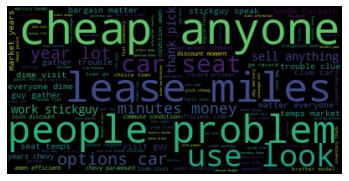

In [71]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

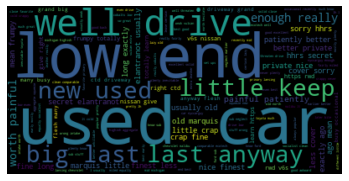

In [72]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Honda energy_management related comment visualization:

In [73]:
honda_energy_management_comment = []
for j in range(len(honda_comment)):
    for i in range(len(honda_comment[j])):
        if honda_comment[j][i] in attributes.energy_management.dropna().tolist():
            honda_energy_management_comment.append(list(set(honda_comment[j])))

In [74]:
honda_energy_management_list = []
for i in range(len(honda_energy_management_comment)):
    for j in range(len(honda_energy_management_comment[i])):
        honda_energy_management_list.append(honda_energy_management_comment[i][j])
text = ' '.join(honda_energy_management_list).lower()
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

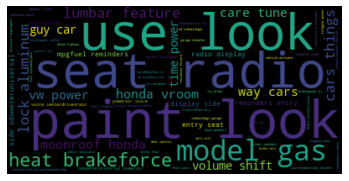

In [75]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

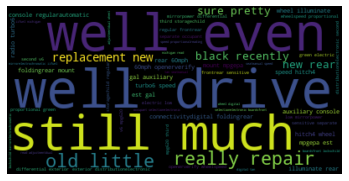

In [76]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Advices for marketing/advertising managers:

One of the most important features of Honda is that the brand is considered to be very cost-efficient. The lift score for the cost-efficient attribute is the highest among all the top 5 brands. Since this is a forum on trade-in values, we can consider Honda to have a relatively high trade-in value among the top 5 brands. The marketing campaign can focus on this attribute. Honda is also strongly associated with the attributes: comfort and interior and sound. However, as discussed above it is considered to be a low-end brand. Thus with a small budget, the buyer can get a really comfortable car with a nice interior. This proves that buying a Honda car is really a good deal. Thus, we believe the advertisement of Honda should definitely contain these key ideas.

#### Honda comfort related comment visualization:

In [77]:
honda_comfort_comment = []
for j in range(len(honda_comment)):
    for i in range(len(honda_comment[j])):
        if honda_comment[j][i] in attributes.comfort.dropna().tolist():
            honda_comfort_comment.append(list(set(honda_comment[j])))

In [78]:
honda_comfort_list = []
for i in range(len(honda_comfort_comment)):
    for j in range(len(honda_comfort_comment[i])):
        honda_comfort_list.append(honda_comfort_comment[i][j])
text = ' '.join(honda_comfort_list).lower()
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

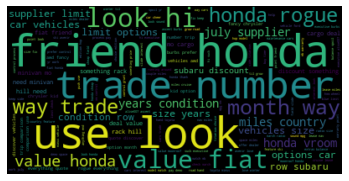

In [79]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

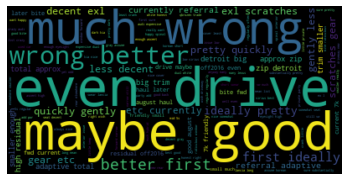

In [80]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

### For Chevrolet

In [81]:
chevrolet_comment = []
for comment in comment_copy:
    if 'chevrolet' in comment:
        chevrolet_comment.append(list(set(comment)))

In [82]:
chevrolet_attr = defaultdict(int)
for comment in chevrolet_comment:
    for attr in detial_attributes:
        if attr in comment:

            chevrolet_attr[attr] +=1
chevrolet_attr = pd.DataFrame(list(zip(chevrolet_attr.keys(), chevrolet_attr.values())),columns =['attribute', 'frequency'])
chevrolet_attr = chevrolet_attr.sort_values(by = 'frequency', ascending= False)

In [83]:
chevrolet_attr.head(10)

,attribute,frequency
6,new,150
9,old,135
15,condition,117
7,lease,94
5,deal,85
33,black,77
32,engine,70
12,repair,53
3,seat,48
36,cheap,48


#### Advices for product managers:

The brands that are highly associated with Chevrolet are Toyota and Ford. Compared to them, Chevrolet is relatively weak in interior and safety. Thus the product managers of Chevrolet should focus on enhancing the brand’s interior design and safety. One of the words that commonly appear in the Chevrolet Wordcloud is “frumpy”. People are considered Chevrolet to be old fashion. Thus product manager might need to focus more on the design of the car.

#### Chevrolet safety related comment visualization:

In [84]:
chevrolet_safety_comment = []
for j in range(len(chevrolet_comment)):
    for i in range(len(chevrolet_comment[j])):
        if chevrolet_comment[j][i] in attributes.safety.dropna().tolist():
            chevrolet_safety_comment.append(list(set(chevrolet_comment[j])))

In [85]:
chevrolet_safety_list = []
for i in range(len(chevrolet_safety_comment)):
    for j in range(len(chevrolet_safety_comment[i])):
        chevrolet_safety_list.append(chevrolet_safety_comment[i][j])
text = ' '.join(chevrolet_safety_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

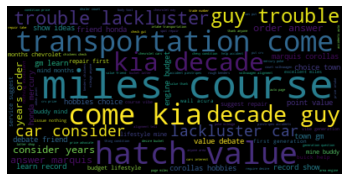

In [86]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

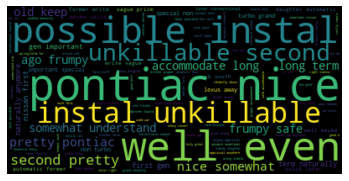

In [87]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Chevrolet interial related comment visualization:

In [88]:
chevrolet_interior_sound_comment = []
for j in range(len(chevrolet_comment)):
    for i in range(len(chevrolet_comment[j])):
        if chevrolet_comment[j][i] in attributes.interior_sound.dropna().tolist():
            chevrolet_interior_sound_comment.append(list(set(chevrolet_comment[j])))

In [89]:
chevrolet_interior_sound_list = []
for i in range(len(chevrolet_interior_sound_comment)):
    for j in range(len(chevrolet_interior_sound_comment[i])):
        chevrolet_interior_sound_list.append(chevrolet_interior_sound_comment[i][j])
text = ' '.join(chevrolet_interior_sound_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

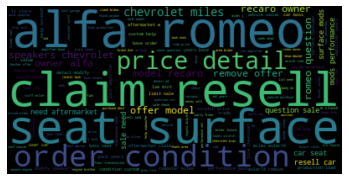

In [90]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

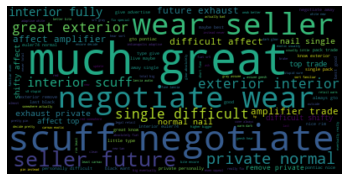

In [91]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

####  Advices for marketing/advertising managers:

Like Honda, Chevrolet is also considered to be cost-efficient. The phrase “good resell” has appeared in Wordcloud several times. Thus, the marketing team should definitely focus on the resell value of Chevrolet. Notably, in the performance Wordcloud, the word “snow” appears multiple times. Chevrolet performs well in snow weather. Thus the marketing team should consider promoting more in the snowy region such as Michigan and Montreal.

#### Chevrolet performance related comment visualization:

In [96]:
chevrolet_performance_comment = []
for j in range(len(chevrolet_comment)):
    for i in range(len(chevrolet_comment[j])):
        if chevrolet_comment[j][i] in attributes.performance.dropna().tolist():
            chevrolet_performance_comment.append(list(set(chevrolet_comment[j])))

In [97]:
chevrolet_performance_list = []
for i in range(len(chevrolet_performance_comment)):
    for j in range(len(chevrolet_performance_comment[i])):
        chevrolet_performance_list.append(chevrolet_performance_comment[i][j])
text = ' '.join(chevrolet_performance_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

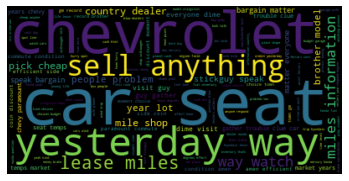

In [98]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

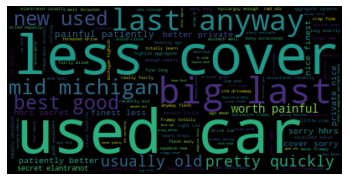

In [99]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

### For Toyota

In [100]:
toyota_comment = []
for comment in comment_copy:
    if 'toyota' in comment:
        toyota_comment.append(list(set(comment)))

In [101]:
toyota_attr = defaultdict(int)
for comment in toyota_comment:
    for attr in detial_attributes:
        if attr in comment:

            toyota_attr[attr] +=1
toyota_attr = pd.DataFrame(list(zip(toyota_attr.keys(), toyota_attr.values())),columns =['attribute', 'frequency'])
toyota_attr = toyota_attr.sort_values(by = 'frequency', ascending= False)

In [102]:
toyota_attr.head(10)

,attribute,frequency
3,new,112
0,condition,107
9,old,104
36,lease,97
5,deal,82
50,repair,72
30,engine,68
38,black,64
10,leather,60
18,cheap,56


#### Advice for product managers:

Toyota is strongly associated with Chevrolet and Fiat. Compared to these two brands, Toyota does not have a strong performance and energy management. Closely examining the Wordclouds generated based on the performance and energy management comment, we found the word “engine” keeps showing up. Also, people mentioned GMC Denali, a very high-performance truck, while discussing Toyota’s energy management. These suggest that Toyota’s product managers really should focus on developing products that can provide better performance and energy management. Moreover, like Honda, Toyota is considered to be a low-end brand. For possible market expansion, the product managers might explore the possibility of developing more high-end models.

#### Toyota performance related comment visualization:

In [103]:
toyota_performance_comment = []
for j in range(len(toyota_comment)):
    for i in range(len(toyota_comment[j])):
        if toyota_comment[j][i] in attributes.performance.dropna().tolist():
            toyota_performance_comment.append(list(set(toyota_comment[j])))

In [104]:
toyota_performance_list = []
for i in range(len(toyota_performance_comment)):
    for j in range(len(toyota_performance_comment[i])):
        toyota_performance_list.append(toyota_performance_comment[i][j])
text = ' '.join(toyota_performance_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

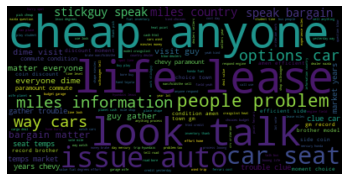

In [105]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

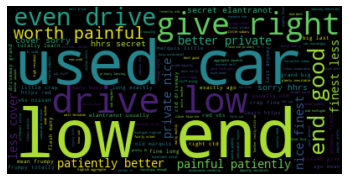

In [106]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Toyota energy_management related comment visualization:

In [107]:
toyota_energy_management_comment = []
for j in range(len(toyota_comment)):
    for i in range(len(toyota_comment[j])):
        if toyota_comment[j][i] in attributes.energy_management.dropna().tolist():
            toyota_energy_management_comment.append(list(set(toyota_comment[j])))

In [108]:
toyota_energy_management_list = []
for i in range(len(toyota_energy_management_comment)):
    for j in range(len(toyota_energy_management_comment[i])):
        toyota_energy_management_list.append(toyota_energy_management_comment[i][j])
text = ' '.join(toyota_energy_management_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

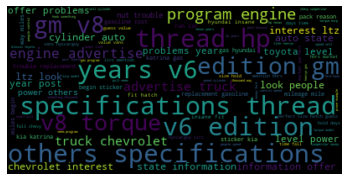

In [109]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

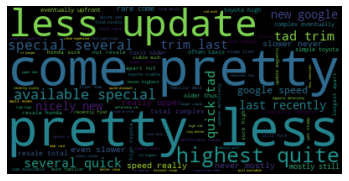

In [110]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Advices for marketing/advertising managers:

One of the attributes that are strongly associated with Toyota is comfort. Based on the Wordcloud analysis, people mentioned drive space and big navigator. People consider it to be low-end but fancy enough. Thus we consider Toyota to be a family-friendly car brand because with a limited budget one can get a fancy enough and spacious car. The marketing direction should focus on building a family-friendly image.

#### Toyota comfort related comment visualization:

In [111]:
toyota_comfort_comment = []
for j in range(len(toyota_comment)):
    for i in range(len(toyota_comment[j])):
        if toyota_comment[j][i] in attributes.comfort.dropna().tolist():
            toyota_comfort_comment.append(list(set(toyota_comment[j])))

In [112]:
toyota_comfort_list = []
for i in range(len(toyota_comfort_comment)):
    for j in range(len(toyota_comfort_comment[i])):
        toyota_comfort_list.append(toyota_comfort_comment[i][j])
text = ' '.join(toyota_comfort_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

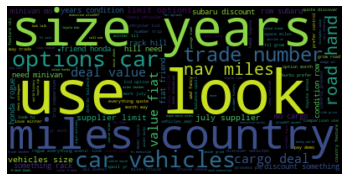

In [113]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

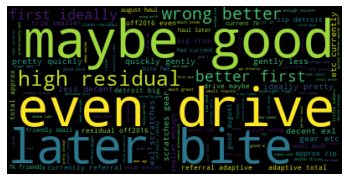

In [114]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

### For Ford

In [115]:
ford_comment = []
for comment in comment_copy:
    if 'ford' in comment:
        ford_comment.append(list(set(comment)))

In [116]:
ford_attr = defaultdict(int)
for comment in ford_comment:
    for attr in detial_attributes:
        if attr in comment:

            ford_attr[attr] +=1
ford_attr = pd.DataFrame(list(zip(ford_attr.keys(), ford_attr.values())),columns =['attribute', 'frequency'])
ford_attr = ford_attr.sort_values(by = 'frequency', ascending= False)

In [117]:
ford_attr.head(10)

,attribute,frequency
9,new,153
14,condition,106
10,deal,95
1,seat,91
5,wheel,88
36,old,82
29,engine,76
12,leather,72
15,interior,69
20,manual,58


#### Advices for product managers:
The brands that are highly associated with Ford are Volkswagen and Subaru. Compared with other brands, Ford is considered to be safer. Thus the product manager should realize this strength and keep the current advantage. However, the product manager should also pay attention to the appearance of the vehicles. According to the text visualization, some words such as ‘frumpy’ and ‘look’ appear frequently, showing that the interior design could be adjusted to further improve the quality.


#### Ford safety related comment visualization:

In [118]:
ford_safety_comment = []
for j in range(len(ford_comment)):
    for i in range(len(ford_comment[j])):
        if ford_comment[j][i] in attributes.safety.dropna().tolist():
            ford_safety_comment.append(list(set(ford_comment[j])))

In [119]:
ford_safety_list = []
for i in range(len(ford_safety_comment)):
    for j in range(len(ford_safety_comment[i])):
        ford_safety_list.append(ford_safety_comment[i][j])
text = ' '.join(ford_safety_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

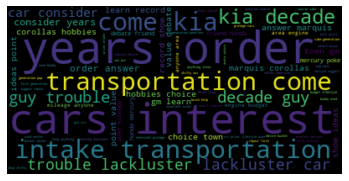

In [120]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

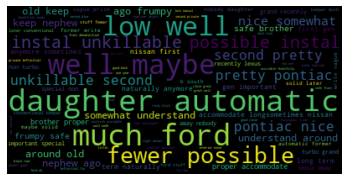

In [121]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Ford appearance related comment visualization:

In [122]:
ford_appearance_comment = []
for j in range(len(ford_comment)):
    for i in range(len(ford_comment[j])):
        if ford_comment[j][i] in attributes.appearance.dropna().tolist():
            ford_appearance_comment.append(list(set(ford_comment[j])))

In [123]:
ford_appearance_list = []
for i in range(len(ford_appearance_comment)):
    for j in range(len(ford_appearance_comment[i])):
        ford_appearance_list.append(ford_appearance_comment[i][j])
text = ' '.join(ford_appearance_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

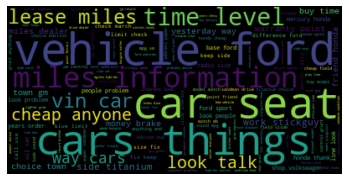

In [124]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

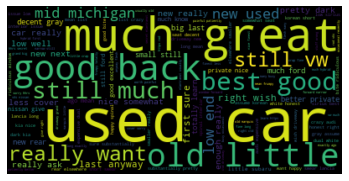

In [125]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Advices for marketing/advertising managers:

Similar to Honda and Chevrolet, Ford is also considered to be cost-efficient. According to Wordcloud, people usually describe Ford to be a good deal, and suitable for ‘commuting’. Thus, the marketing team should potentially adjust the market positioning strategy accordingly and focus more on those people with higher demand on daily commuting. In addition, Ford brings comfort to drivers, showing it is also suitable for short business trips by car. Thus, the market team should consider promoting more advertisements in the business district.

#### Ford performance related comment visualization:

In [126]:
ford_peformance_comment = []
for j in range(len(ford_comment)):
    for i in range(len(ford_comment[j])):
        if ford_comment[j][i] in attributes.appearance.dropna().tolist():
            ford_peformance_comment.append(list(set(ford_comment[j])))

In [127]:
ford_performance_list = []
for i in range(len(ford_peformance_comment)):
    for j in range(len(ford_peformance_comment[i])):
        ford_performance_list.append(ford_peformance_comment[i][j])
text = ' '.join(ford_performance_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

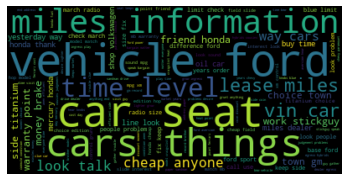

In [128]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

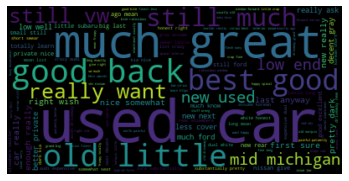

In [129]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

### For Fiat:

In [130]:
fiat_comment = []
for comment in comment_copy:
    if 'fiat' in comment:
        fiat_comment.append(list(set(comment)))

In [131]:
fiat_attr = defaultdict(int)
for comment in fiat_comment:
    for attr in detial_attributes:
        if attr in comment:

            fiat_attr[attr] +=1
fiat_attr = pd.DataFrame(list(zip(fiat_attr.keys(), fiat_attr.values())),columns =['attribute', 'frequency'])
fiat_attr = fiat_attr.sort_values(by = 'frequency', ascending= False)

In [132]:
fiat_attr.head(10)

,attribute,frequency
18,new,84
10,condition,73
5,deal,57
1,black,56
55,old,54
35,lease,52
0,leather,45
9,manual,44
11,mileage,44
31,seat,42


#### Advices for product managers:

The brands that are highly associated with Fiat are Nissan and BMW. But by the text visualization, people mention ‘damage’ and ‘accident’ frequently. So Fiat’s product manager should definitely focus on improving driving safety, and the tire value, in particular. In addition, customers seem to appreciate those electrical vehicles more, compared with those ones involving traditional gas for energy. In this case, the product manager should also concentrate on the product transformation, and produce more vehicles popular among customers.

#### Fiat safety related comment visualization:

In [133]:
fiat_safety_comment = []
for j in range(len(fiat_comment)):
    for i in range(len(fiat_comment[j])):
        if fiat_comment[j][i] in attributes.safety.dropna().tolist():
            fiat_safety_comment.append(list(set(fiat_comment[j])))

In [134]:
fiat_safety_list = []
for i in range(len(fiat_safety_comment)):
    for j in range(len(fiat_safety_comment[i])):
        fiat_safety_list.append(fiat_safety_comment[i][j])
text = ' '.join(fiat_safety_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

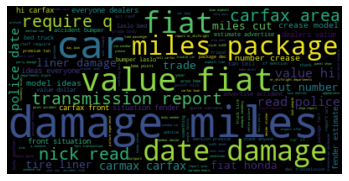

In [135]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

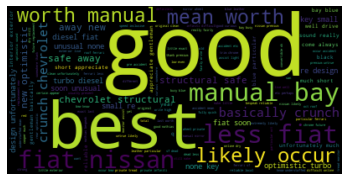

In [136]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Fiat energy_management related comment visualization:

In [137]:
fiat_energy_management_comment = []
for j in range(len(fiat_comment)):
    for i in range(len(fiat_comment[j])):
        if fiat_comment[j][i] in attributes.energy_management.dropna().tolist():
            fiat_energy_management_comment.append(list(set(fiat_comment[j])))

In [138]:
fiat_energy_management_list = []
for i in range(len(fiat_energy_management_comment)):
    for j in range(len(fiat_energy_management_comment[i])):
        fiat_energy_management_list.append(fiat_energy_management_comment[i][j])
text = ' '.join(fiat_energy_management_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

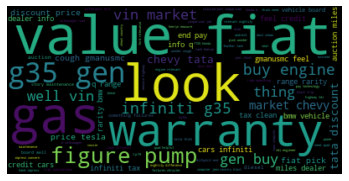

In [139]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

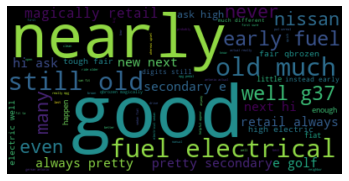

In [140]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Advices for marketing/advertising managers:

According to Wordcloud, customers value the vehicle's appearance a lot by frequently mentioning the pretty colors and the right size for the garage. Thus, the marketing manager should emphasize the well-designed outlook and its convenience for crowded places. Moreover, similar to Chevrolet, Fiat is considered to be a ‘snow brother’ and is appreciated for its suitability for driving on snow. In this case, the advertising team should invest more in those snowy regions in the north.


#### Fiat performance related comment visualization:

In [141]:
fiat_performance_comment = []
for j in range(len(fiat_comment)):
    for i in range(len(fiat_comment[j])):
        if fiat_comment[j][i] in attributes.performance.dropna().tolist():
            fiat_performance_comment.append(list(set(fiat_comment[j])))

In [142]:
fiat_performance_list = []
for i in range(len(fiat_performance_comment)):
    for j in range(len(fiat_performance_comment[i])):
        fiat_performance_list.append(fiat_performance_comment[i][j])
text = ' '.join(fiat_performance_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

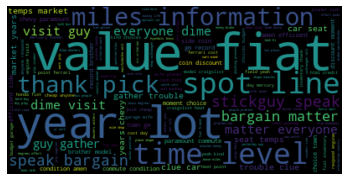

In [143]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

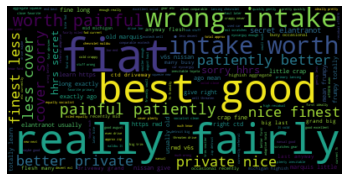

In [144]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

## Task: Discover the most aspirational brand in the discussion

The definition of the aspirational brand found from literature search:

The aspirational brand means which brand:

    1) People want to own, but not already owned for now
    2) And the motivation of wants should be related to the brand's emotional value.
    3) It should be achievable (to delineate the concept from just 'luxurious' brands)

But the third definition can not be described from the current dataset; in field research, the survey method is usually utilized to distinguish an aspirational brand from a luxury brand. (reference: I've Wanted A BMW Since I Was A Kid: An Exploratory Analysis Of The Aspirational Brand, 2015, The Journal of Applied Business Research) Therefore, I decided to focus on finding the set of terms that can serve the definition no.1 and no.2. 


Methodology (Steps)

* to define 'aspirational words' in the given dataset

    * scope to 'adj' words using nltk tagging
    * using VADER, gauge positive score of each word
    * filter only with positivity score is greater than 0.5
    * manually delete irrelevant words from positive word set
    * manually delete functional positivity words from positive word set
        * positive word set consists of 'functional positivity (including 'value for money" and 'emotional positivity' - I decided to keep only 'emotional' part.
    
* With the derived aspirational list of words, calculate lift value for the top 10 brands.
   * only keep rows whose lift value is greater than 1 
* From the lift scores, calculate 'average lift' with aspirational terms per brand.
* The brand shows the highest mean of lifts among aspirational terms is the most aspirational brand.

In [151]:
wordlist = []
for i in range(len(target_comment)):
    for j in range(len(target_comment[i])):
        wordlist.append(target_comment[i][j])
text = ' '.join(wordlist).lower()

In [152]:
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]

### Define aspiration word set

In [153]:
#using VADER, gauge positive score of each word 
#and narrow down the words of interest with positivity score is greater than 0.5

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer() 
#sent.polarity_scores('like')

pos_word_dict = {} 
for i in adj_list: #adj_list
    if sent.polarity_scores(i)['pos'] > 0.5:  #filter with positivity score > 0.5
        pos_word_dict[i] = sent.polarity_scores(i)['pos']
        #print(i, sent.polarity_scores(i), sent.polarity_scores(i)['pos'])
    
#pos_word_dict

In [154]:
pos_list = list(pos_word_dict.keys())

In [155]:
#eliminate irrelevant words from pos_list
irr_list = ['ha','thanks-', 'well-', 'yay','hug','pray', 'truer','fiestas','gl','fresh', 'bless','smile', 'admit', 'sure', 'highlight','grant','forgiveness', 'agree', 'forgive', 'popular','thank', 'generous', 'clear', 'silly', 'curious', 'certainly', 'welcome', 'yeah', 'peculiar', 'definitely', 'luckily', 'honest', 'nicely', 'certain', 'straight', 'ok', 'honesty', 'create', 'please', 'win', 'grey', 'true', 'honestly', 'convince', 'ready', 'thankfully', 'dear', 'kiss', 'gently', 'yes', 'truly', 'extend', 'strongly', 'hopefully', 'carefully', 'important', 'matter', 'friendly', 'tx', 'tia', 'substantial', 'courtesy', 'clearly', 'respectively', 'greater', 'allow', 'join', 'humorous', 'treat', 'definite', 'funny', 'friend', 'greet', 'optimistically', 'gla', 'agreeable', 'invite', 'lol', 'surprise', 'sigh', 'apologize', 'excuse', 'ly', 'sunny', 'god', 'acceptable', 'okay', 'yep', 'casually', 'ftw', 'alert', 'hilarious', 'accept', 'sincerely', 'importantly', 'respectfully', 'nh', 'laugh', 'goodness', 'reach', 'positively', 'resolve', 'luckier', 'natural', 'fyi', 'thx', 'friends', 'surprisingly', 'truthfully', 'surely', 'truth', 'relieve', 'haha']
pos_list = [item for item in pos_list if item not in irr_list]

#eliminate functional positivity related words
func_list = ['prevent','support','adopt','clean','solve','tolerance','incentive', 'huge', 'helpful', 'easily', 'comfortable','scoop', 'profitable', 'protect', 'defensive', 'careful', 'easier', 'fit', 'smart', 'gt', 'freeway', 'care', 'easy', 'recommend', 'safe', 'casual', 'solid', 'save', 'responsible', 'useful', 'efficient', 'benefit', 'legal', 'stealthily', 'effectively', 'improve', 'reward', 'capable', 'healthy', 'effective', 'stable', 'powerful', 'easiest', 'comprehensive', 'warm', 'help', 'safely', 'faithful', 'incentives', 'painless', 'cleaner', 'mandatory']
pos_list = [item for item in pos_list if item not in func_list]

In [156]:
aspirations = pos_list

In [157]:
len(aspirations)

128

### Calculate lift value for the combination of aspiration terms and the top 10 brands

In [158]:
#Make combination of Top 10 Brand and aspirations
import itertools
comb = list(itertools.product(top_10,aspirations))

In [159]:
# Calculate Brand frequency
brand_dict = {}
for (key, value) in brand_frequency.items():
    if key in top_10:
        brand_dict[key] = value

In [160]:
# Calculate aspirational words' mentioned frequency
asp_frequency = defaultdict(int)
for comment in processed_text: 
    for words in comment: 
        if words in aspirations:
            asp_frequency[words]+=1

#asp_frequency

In [161]:
# Calculate the #(A,B); pair frequency
pair_frequency = defaultdict(int)
for pair in comb:
    for comm in target_comment_distinct:
        if pair[0] in comm and pair[1] in comm:
            pair_frequency[pair] +=1

In [162]:
#calculate 'liftA'; lift values for aspirations - brands
liftA = {}
for i in pair_frequency.keys():
    #print(pair_frequency[i], brand_dict[i[0]], asp_frequency[i[1]])
    liftA[i] = i[0], (5000*pair_frequency[i]) / (brand_dict[i[0]]*asp_frequency[i[1]])

In [163]:
#only keep rows whose lift value > 1 
df_A = pd.DataFrame.from_dict(liftA, orient='index', columns=['brand','lift'])
df_A.sort_values(ascending = True, by = 'lift').head(30)
df_A = df_A[df_A.lift > 1]

### Find out the most aspirational brand - utilizing mean of aspirational lifts per brand

In [164]:
#Calculate 'average lift' with aspirational terms per brand
df_asp = df_A.groupby('brand').mean().sort_values(ascending = False, by = 'lift')

In [165]:
#find out the most aspirational brand
print('\n \033[1m' + 'Subaru is the "Most Aspirational" Brand ' + '\033[0m')
print('\n Brands and Lift Values:')
display(df_asp)


 Subaru is the "Most Aspirational" Brand 

 Brands and Lift Values:


,lift
brand,
subaru,6.470623
audi,5.185672
nissan,5.182196
ford,4.789472
volkswagen,4.634353
toyota,4.580301
chevrolet,4.462296
bmw,4.206186
honda,3.550928


From the research, we could prove that the high aspirational orientation was actually realized as the market performance of the brand. From the below chart, we can see that the units sold of Subra in the United States from 2001 to 2019 ( IHS Global Intelligence - Automotive Market Database (released in April, 2019)) soared with 8% of CAGR. Segment-wise, the SUV(Sports Utility Vehicle) models are in orange colours, and the sedan models are in green colours. We can also find out that Subaru’s new car sales are leveraged by SUV models significantly; in 2019, SUV models accounted for more than half of Subaru’s annual sales.

Moreover, connected to the terms such as ‘enjoyable,’ which Subaru showed the maximum lift among brands, we can infer that from 2001 to 2019, the direction of aspirations changed from family sedans to sporty vehicles in the United States passenger car market, as shown in the historical new car sales broken down into segment in the chart. (IHS Global Intelligence - Automotive Market Database (released in April, 2019))


In conclusion, Subaru’s SUV portfolios successfully positioned in growing sporty vehicles demand in the United States, and it led to the high aspirational orientation in consumer’s perception and turned out to increase in sales.